## Assessing the ability to identify less reliable antibodies using mRNA-RPPA and MS-RPPA correlations

**Input:**  
- Processed CCLE mRNA-protein correlation and MS-RPPA correlation (Source Data for Figure 4)
- Aggregated protein reproducibility ranks, Protein and mRNA abundance (Source Data for Figure S5)

**Output:**  
- Figure 5

### Import Packages

In [1]:
import os, re
import numpy as np
import pandas as pd
import seaborn as sns
import itertools

%matplotlib inline

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import graphing_utils as gu
import customized_plot 
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
get_data_path = lambda folders, fname: os.path.normpath(os.environ['DATA_PATH']+'/'+'/'.join(folders) +'/'+ fname)
get_table_path = lambda fname: os.path.normpath('../tables/' + fname)
get_figure_path = lambda fname: os.path.normpath('../figures/' + fname)

In [3]:
file_sourceData_Figure4 = get_table_path('SourceDataForFigure4.csv')
file_sourceData_FigureS5 = get_table_path('SourceDataForFigureS5.csv')
file_sourceData_Figure5 = get_table_path('SourceDataForFigure5.csv')

### Load data

In [4]:
ccle_data = pd.read_csv(file_sourceData_Figure4, index_col=0)
ccle_data[:2]

,mRNA_RPPA_cor,mRNA_MS_cor,RPPA-MS cor,ValidationStatus
ACACA,0.566263,0.371653,0.518745,Use with Caution
ACTB,0.386765,0.481398,0.380440,Use with Caution


In [5]:
ccle_classification_data = ccle_data[['mRNA_RPPA_cor', 'RPPA-MS cor', 'ValidationStatus']]
ccle_classification_data[:2]

,mRNA_RPPA_cor,RPPA-MS cor,ValidationStatus
ACACA,0.566263,0.518745,Use with Caution
ACTB,0.386765,0.380440,Use with Caution


In [6]:
properties = pd.read_csv(file_sourceData_FigureS5, index_col=0)
properties[:2]

,Aggregated Reproducibility Rank,mRNA_Mean_Abundance,protein_Mean_Abundance,ValidationStatus
ACACA,0.453268,NaN,9.470895,Use with Caution
ACTB,0.629004,3.519282,NaN,Use with Caution


In [7]:
classification_data = pd.concat([ccle_classification_data, properties[['Aggregated Reproducibility Rank', 
                                                                      'mRNA_Mean_Abundance',
                                                                      'protein_Mean_Abundance']]], axis=1, join='inner')
classification_data.reindex(['mRNA_RPPA_cor', 'RPPA-MS cor', 'Aggregated Reproducibility Rank', 
                             'mRNA_Mean_Abundance', 'protein_Mean_Abundance', 'ValidationStatus'], axis=1)
classification_data[:2]

,mRNA_RPPA_cor,RPPA-MS cor,ValidationStatus,Aggregated Reproducibility Rank,mRNA_Mean_Abundance,protein_Mean_Abundance
ACACA,0.566263,0.518745,Use with Caution,0.453268,NaN,9.470895
ACTB,0.386765,0.380440,Use with Caution,0.629004,3.519282,NaN


In [8]:
ccle_no_missing_features = classification_data.dropna()
ccle_no_missing_features.shape

(71, 6)

In [9]:
lda = LinearDiscriminantAnalysis()
def draw_roc_curve(data, features, color, ax): 
    feature_columns = features
    X = data.dropna(subset=feature_columns + ['ValidationStatus']).drop(columns='ValidationStatus')[feature_columns]
    y = data['ValidationStatus'].reindex(X.index)
    y = y.replace('Valid', 1).replace('Use with Caution', 0)
    if(isinstance(X, pd.Series)==True):
        X = X.values.reshape(-1, 1)
    
    y_pred = lda.fit(X, y).predict_proba(X)[::,1]
    fpr, tpr, _ = roc_curve(y, y_pred)
    label = 'LDA (%.2f)' % (auc(fpr, tpr))
    line_kwargs = {"drawstyle":"steps-post"}
    ax.step(fpr, tpr, label=label, color=color, zorder=10, **line_kwargs)    
    ax.plot([0,1], [0,1], linestyle='--', color='black', label='Chance (0.50)')
    ax.set_xlabel('False Positive Rate', fontsize=11); ax.set_ylabel('True Positive Rate', fontsize=11)
    ax.legend(loc="lower right", bbox_to_anchor=(1,0), fontsize=10)
    
def get_auroc_score(data, features):
    auroc = {}
    
    feature_columns = list(features)
    X = data.dropna(subset=feature_columns + ['ValidationStatus']).drop(columns='ValidationStatus')[feature_columns]
    y = data['ValidationStatus'].reindex(X.index)
    y = y.replace('Valid', 1).replace('Use with Caution', 0)
       
    y_pred = lda.fit(X, y).predict_proba(X)
    auroc[' + '.join(feature_columns)] = roc_auc_score(y, y_pred[:, 1])

    return(pd.DataFrame.from_dict(auroc, orient='index'))

In [10]:
feature_names = ['mRNA_RPPA_cor', 'RPPA-MS cor', 'Aggregated Reproducibility Rank',
                 'mRNA_Mean_Abundance', 'protein_Mean_Abundance']
feature_colors = [gu.get_color(name) for name in ['orange', 'green', 'blue', 'yellow', 'light-blue-ot']]
# All pairwise screens combos
single_feature_combo = [pair for pair in itertools.combinations(feature_names, r=1)] 
two_features_combo = [pair for pair in itertools.combinations(feature_names, r=2)] 
three_features_combo = [pair for pair in itertools.combinations(feature_names, r=3)] 
four_features_combo = [pair for pair in itertools.combinations(feature_names, r=4)] 
five_features_combo = [pair for pair in itertools.combinations(feature_names, r=5)] 

all_features = single_feature_combo + two_features_combo + three_features_combo + four_features_combo + five_features_combo

In [11]:
auroc = pd.concat([get_auroc_score(ccle_no_missing_features, c) for c in all_features]).rename(columns={0: 'AUROC (LDA)'})
auroc = auroc.replace('protein_Mean_Abundance', 
                      'Protein mean abundance', regex=True).replace('mRNA_Mean_Abundance', 
                                                                    'mRNA mean abundance', 
                                                                    regex=True).replace('mRNA_RPPA_cor', 
                                                                                        'CCLE mRNA-protein rho', 
                                                                                        regex=True).replace('RPPA-MS cor', 
                                                                                                            'CCLE RPPA-MS rho')
auroc

,AUROC (LDA)
mRNA_RPPA_cor,0.622609
RPPA-MS cor,0.673043
Aggregated Reproducibility Rank,0.650435
mRNA_Mean_Abundance,0.494783
protein_Mean_Abundance,0.580000
mRNA_RPPA_cor + RPPA-MS cor,0.680870
mRNA_RPPA_cor + Aggregated Reproducibility Rank,0.659130
mRNA_RPPA_cor + mRNA_Mean_Abundance,0.625217
mRNA_RPPA_cor + protein_Mean_Abundance,0.620000
RPPA-MS cor + Aggregated Reproducibility Rank,0.686087


In [12]:
# Code adapted from De Kegel et al. (2021) Comprehensive prediction of robust synthetic 
# lethality between paralog pairs in cancer cell lines. Cell Systems

single_feature_idx = [feature_names.index(c[f])+(i*5) for i, c in enumerate(single_feature_combo) for f in range(len(c))]
two_feature_idx = [feature_names.index(c[f])+(i*5)+25 for i, c in enumerate(two_features_combo) for f in range(len(c))]
three_feature_idx = [feature_names.index(c[f])+(i*5)+75 for i, c in enumerate(three_features_combo) for f in range(len(c))]
four_feature_idx = [feature_names.index(c[f])+(i*5)+125 for i, c in enumerate(four_features_combo) for f in range(len(c))]
five_features_idx = [feature_names.index(c[f])+(i*5)+150 for i, c in enumerate(five_features_combo) for f in range(len(c))]
idx = single_feature_idx + two_feature_idx + three_feature_idx + four_feature_idx + five_features_idx

c = np.array(['#ddd'] * len(all_features) * len(feature_names), dtype='O')
c[idx] = [feature_colors[i%5] for i in idx]

# Set circle border color
c_border = np.array(['#ddd'] * len(all_features) * len(feature_names), dtype='O')
c_border[idx] = ['grey' for i in idx]


# x-y grid is screen pairs by screens
x = np.repeat(np.arange(len(all_features)), len(feature_names))


y = np.tile(np.arange(len(feature_names)), len(all_features))


feature_names = ['CCLE mRNA-protein correlation', 'CCLE RPPA-MS correlation', 'Aggregated Protein Reproducibility Rank',
                 'mRNA mean abundance', 'Protein mean abundance']

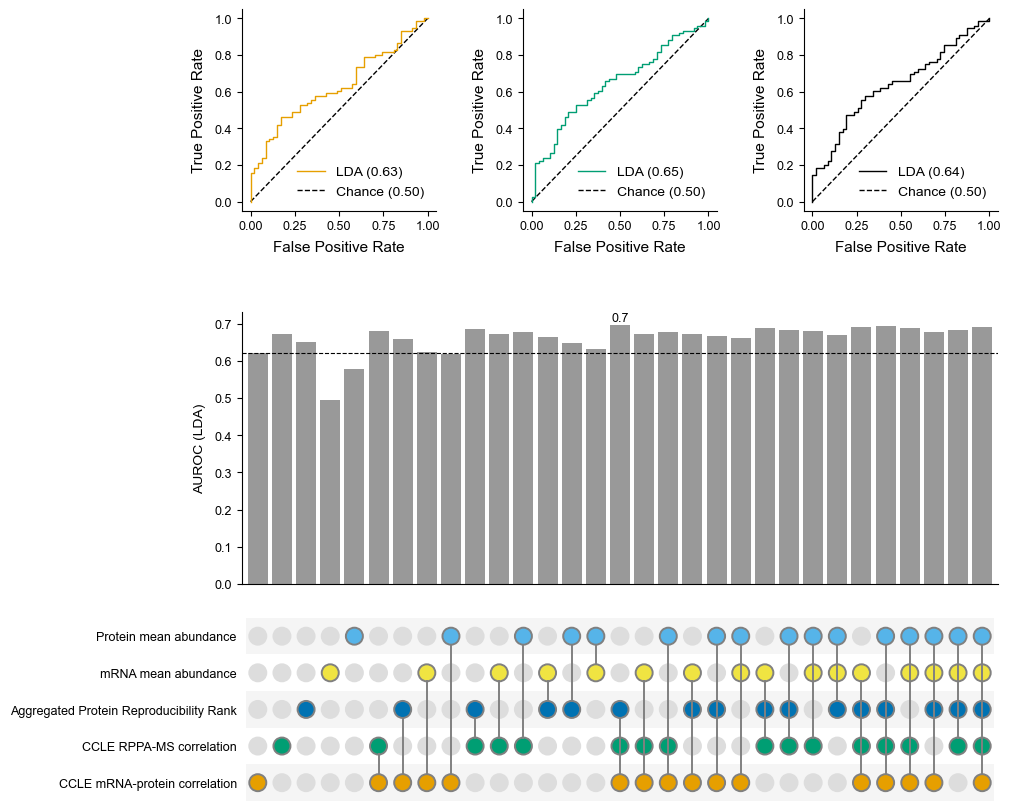

In [13]:
with plt.rc_context({'axes.linewidth': 0.8, 'axes.labelsize':10, 'axes.spines.left': True, 'xtick.labelsize':9}):
    gs_kw = dict(height_ratios=[1, 0.2, 1.35, 1])
    figure, ax = plt.subplot_mosaic([['first left', 'first middle', 'first right'], 
                                     ['second', 'second', 'second'],
                                     ['third', 'third', 'third'], 
                                     ['fourth', 'fourth', 'fourth']],
                              gridspec_kw=gs_kw, figsize=(10, 8),
                              layout="constrained")
    # draw roc curves in the first axes
    draw_roc_curve(classification_data, ['mRNA_RPPA_cor'], '#E69F00', ax['first left'])
    draw_roc_curve(classification_data, ['RPPA-MS cor'], '#009E73', ax['first middle'])
    draw_roc_curve(classification_data, ['mRNA_RPPA_cor', 'RPPA-MS cor'], '#000', ax['first right'])
    
    # Second axis is used to create space between the ROC curves and the upset plot
    ax['second'].set_visible(False)
    
    # Fourth axis represents the features used 
    ax['fourth'].scatter(x, y, c=c.tolist(), edgecolor=c_border.tolist(), linewidth=1.4, s=150, zorder=1)
    # Draw lines between the circles
    vline_data = (pd.Series(y[idx], index=x[idx]).groupby(level=0).aggregate(['min', 'max']))
    ax['fourth'].vlines(vline_data.index.values[5:], vline_data['min'][5:]+0.2, vline_data['max'][5:]-0.2, 
                        lw=1.4, colors='grey')    
    # Set ticks
    ax['fourth'].yaxis.set_ticks(np.arange(len(feature_names)))
    ax['fourth'].yaxis.set_ticklabels(feature_names, rotation=0, fontsize=9)
    ax['fourth'].xaxis.set_visible(False)
    ax['fourth'].tick_params(axis='both', which='both', length=0)
    ax['fourth'].set_frame_on(False)
    ax['fourth'].set_xlim([-0.5, len(all_features)])
    ax['fourth'].set_ylim([-0.5, len(feature_names)])    
    # Color background
    for i in range(0, 6, 2):
        rect = plt.Rectangle([-0.5,-0.5+i], 31, 1, facecolor='#f5f5f5', lw=0, zorder=0)
        ax['fourth'].add_patch(rect)
    
    # Make the bars share the x-axis with scatterplot for the Upset plot
    ax['third'].get_shared_x_axes().join(ax['third'], ax['fourth'])
    
    # Plot bar chart part of upset plot 
    auroc.plot.bar(ax=ax['third'], color=['#999'], width=0.83)
    gu.set_axis_props(ax['third'], show_xticks=False, ylabel='AUROC (LDA)')
    ax['third'].hlines(auroc.loc['mRNA_RPPA_cor', 'AUROC (LDA)'], 
               ax['third'].get_xlim()[0], ax['third'].get_xlim()[1], lw=0.8, colors='black', linestyles='dashed')
    ax['third'].annotate(str(round(auroc['AUROC (LDA)'].max(), 2)), 
               (list(auroc.index).index(auroc[auroc['AUROC (LDA)'] == auroc['AUROC (LDA)'].max()].index[0]) - 0.35, 
                auroc['AUROC (LDA)'].max() + 0.01))
    ax['third'].get_legend().remove()
#     figure.savefig(get_figure_path('Figure5.svg'), bbox_inches='tight', dpi=300)

In [14]:
auroc.to_csv(file_sourceData_Figure5)